<a href="https://colab.research.google.com/github/seyhuni/Okculuk/blob/main/OkculukTOTAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Veri Yükleme
signals = pd.read_csv('signal2.csv', header=None).values  # (60, 1700)
labels = pd.read_csv('qe_duration2.csv', header=None).values  # (60, 1700)

# Normalizasyon (Z-score)
signals = (signals - np.mean(signals, axis=1, keepdims=True)) / np.std(signals, axis=1, keepdims=True)

# --- 1. Time Shift Fonksiyonu ---
def time_shift(data, labels, shift_range=10):
    shifted_data = []
    shifted_labels = []
    for i in range(data.shape[0]):
        shift = np.random.randint(-shift_range, shift_range)
        shifted_data.append(np.roll(data[i], shift))
        shifted_labels.append(np.roll(labels[i], shift))
    return np.array(shifted_data), np.array(shifted_labels)

# --- 2. Gaussian Noise Ekleyelim ---
def add_gaussian_noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

# **Orijinal ve Augmented Veriyi Hazırlama**
X_train, X_test, Y_train, Y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)

# Time Shift Augmentation
aug_signals_train, aug_labels_train = time_shift(X_train, Y_train)
aug_signals_test, aug_labels_test = time_shift(X_test, Y_test)

# Gaussian Noise Augmentation
noise_signals_train = add_gaussian_noise(X_train)
noise_signals_test = add_gaussian_noise(X_test)

# **Verileri Birleştirme**
X_train = np.concatenate([X_train, aug_signals_train, noise_signals_train], axis=0)
Y_train = np.concatenate([Y_train, aug_labels_train, Y_train], axis=0)

X_test = np.concatenate([X_test, aug_signals_test, noise_signals_test], axis=0)
Y_test = np.concatenate([Y_test, aug_labels_test, Y_test], axis=0)

# **Boyut Kontrolü**
print("X_train Shape:", X_train.shape)  # (180, 1700)
print("X_test Shape:", X_test.shape)    # (60 → 180 olmalı)

# Model için reshape
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


X_train Shape: (144, 1700)
X_test Shape: (36, 1700)


In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, UpSampling1D, Bidirectional, MaxPooling1D
from tensorflow.keras.models import Sequential  # Import Sequential here

# CNN+LSTM Modeli
def build_cnn_lstm_model(input_shape):
    model = Sequential()

    # CNN Katmanları (Azaltılmış Filtre ve L2 Regularization)
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM Katmanları (Daha Az Katman)
    model.add(Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.001))))
    #model.add(Bidirectional(LSTM(200, return_sequences=True)))

    model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001))))
    #model.add(Bidirectional(LSTM(100, return_sequences=True)))

    #model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001))))

    # Çıkışı Orijinal Boyuta Döndürme
    model.add(UpSampling1D(size=2))
    model.add(UpSampling1D(size=2))

    # Tam Bağlantılı Katman
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # Çıkış Katmanı (Sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    return model



In [7]:
cnnlstmmodel = build_cnn_lstm_model((1700, 1))
cnnlstmmodel.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1700, 64)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1700, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 850, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 850, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 850, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 425, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 425, 400)            │         526,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 425, 200)            │         400,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 425, 100)            │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 850, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 1700, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1700, 50)            │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1700, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1700, 1)             │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,058,557 (4.04 MB)

 Trainable params: 1,058,173 (4.04 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

cnnlstmmodel.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Callback'ler
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)

# Modeli Eğitme
history = cnnlstmmodel.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=8, callbacks=[early_stopping, lr_scheduler])

# Modeli Kaydetme
cnnlstmmodel.save('cnn_lstm_okculuk_model.h5')


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.7576 - loss: 2.1546 - val_accuracy: 0.9096 - val_loss: 1.9689 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9079 - loss: 1.7161 - val_accuracy: 0.9096 - val_loss: 1.5885 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9124 - loss: 1.4392 - val_accuracy: 0.9096 - val_loss: 1.3132 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9149 - loss: 1.2091 - val_accuracy: 0.9080 - val_loss: 1.2500 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9043 - loss: 1.0697 - val_accuracy: 0.9036 - val_loss: 1.2044 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9122 - loss: 0.9141 - val_accuracy: 0.9043 - val_loss: 1.1476 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9

In [33]:
from matplotlib.font_manager import FontProperties
font_path = '/content/times.ttf'  # Replace with the actual path
font_prop = FontProperties(fname=font_path)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


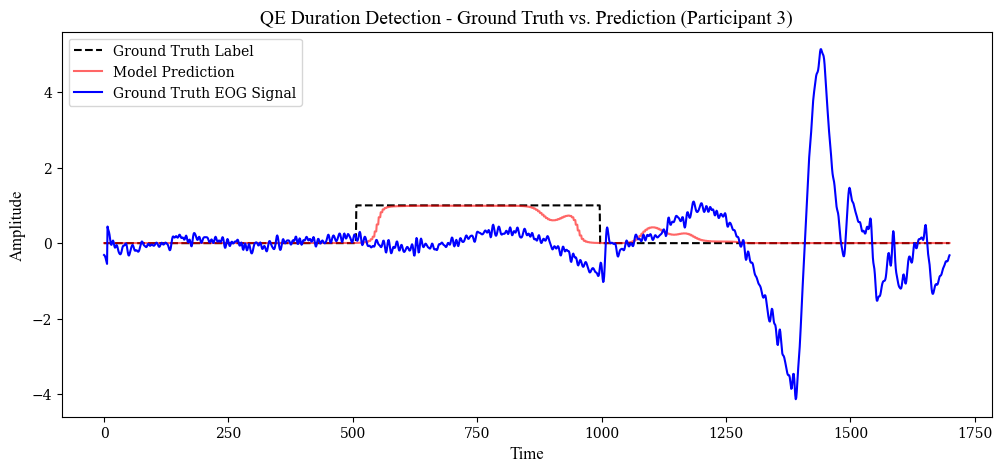

In [67]:
import matplotlib.pyplot as plt

# Modeli Yükleme ve Tahmin Yapma
predictions = cnnlstmmodel.predict(X_test)  # (60, 1700)

# Örnek Bir Test Verisi için Görselleştirme #görselleştireceğim test verileri 2-1, 5-2, 23-3, 12-4
test_index = 23
plt.figure(figsize=(12, 5))
plt.plot(Y_test[test_index], label='Ground Truth Label', color='black', linestyle='dashed')
plt.plot(predictions[test_index], label='Model Prediction',color='red', alpha=0.6)
plt.plot(X_test[test_index], label='Ground Truth EOG Signal', color='blue')

plt.legend()
plt.title('QE Duration Detection - Ground Truth vs. Prediction (Participant 3)', fontproperties=font_prop, size=14)
plt.xlabel('Time', fontproperties=font_prop,size=12)
plt.ylabel('Amplitude', fontproperties=font_prop,size=12)
# Yüksek çözünürlükle kaydetme (600 DPI)
plt.savefig('qe_prediction_cnnlstm_plot_participant3.png', dpi=600, bbox_inches='tight')

# Görseli gösterme
plt.show()


In [68]:
loss, accuracy = cnnlstmmodel.evaluate(X_test, Y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9281 - loss: 0.4489


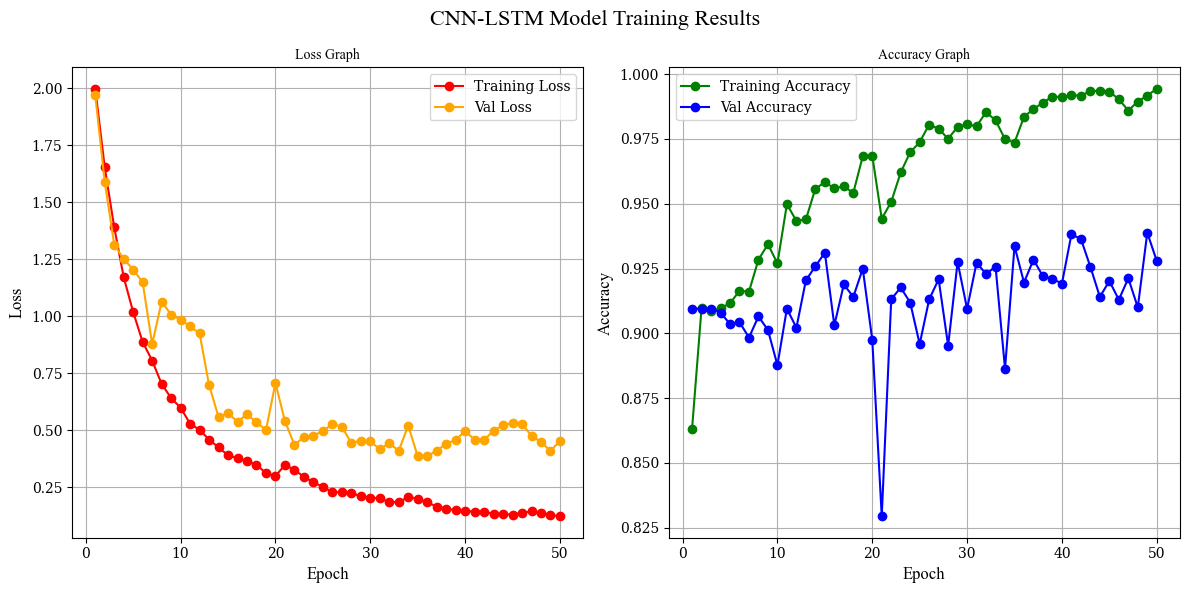

In [75]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path = '/content/times.ttf'  # Replace with the actual path
font_prop = FontProperties(fname=font_path)


# Model eğitimi sırasında elde edilen loss ve accuracy değerlerini history nesnesinden alıyoruz
# history = model.fit(...) işleminden sonra elde edilen sonuçlar
# history.history['loss'] ve history.history['accuracy'] ile erişilebilir

# Örnek history verisi (gerçek training işlemi sırasında history nesnesini kullanmalısınız)

# Eğitim geçmişinden loss ve accuracy değerlerini alıyoruz
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # Epoch sayısı

# Grafiği oluşturma
plt.figure(figsize=(12, 6))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='red', linestyle='-', marker='o')
plt.title('Loss Graph', fontsize=14, fontproperties=font_prop)
plt.plot(epochs, val_loss, label='Val Loss', color='orange', linestyle='-', marker='o')
plt.title('Loss Graph', fontsize=14, fontproperties=font_prop)
plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
plt.ylabel('Loss', fontsize=12, fontproperties=font_prop)
plt.grid(True)
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='green', linestyle='-', marker='o')
plt.title('Accuracy Graph', fontsize=14, fontproperties=font_prop)
plt.plot(epochs, val_accuracy, label='Val Accuracy', color='blue', linestyle='-', marker='o')
plt.title('Accuracy Graph', fontsize=14, fontproperties=font_prop)
plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
plt.ylabel('Accuracy', fontsize=12, fontproperties=font_prop)
plt.grid(True)
plt.legend()

# Genel başlık
plt.suptitle('CNN-LSTM Model Training Results', fontsize=16, fontproperties=font_prop)

# Görseli gösterme
plt.tight_layout()
plt.savefig('CNN-LSTM Model Results.png', dpi=600, bbox_inches='tight')

# Görseli gösterme
plt.show()


In [76]:
###### CNN + GRU MODEL ########

In [77]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, LSTM, Dense, GRU, Dropout, BatchNormalization, UpSampling1D, Bidirectional, MaxPooling1D

# CNN+GRU Modeli
def build_cnn_gru_model(input_shape):
    model = Sequential()

    # CNN Katmanları (Azaltılmış Filtre ve L2 Regularization)
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM Katmanları (Daha Az Katman)
    model.add(Bidirectional(GRU(200, return_sequences=True, kernel_regularizer=l2(0.001))))
    #model.add(Bidirectional(LSTM(200, return_sequences=True)))

    model.add(Bidirectional(GRU(100, return_sequences=True, kernel_regularizer=l2(0.001))))
    #model.add(Bidirectional(LSTM(100, return_sequences=True)))

    #model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(GRU(50, return_sequences=True, kernel_regularizer=l2(0.001))))

    # Çıkışı Orijinal Boyuta Döndürme
    model.add(UpSampling1D(size=2))
    model.add(UpSampling1D(size=2))

    # Tam Bağlantılı Katman
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # Çıkış Katmanı (Sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    return model



In [78]:
cnngrumodel = build_cnn_gru_model((1700, 1))
cnngrumodel.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 1700, 64)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1700, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 850, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 850, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 850, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 425, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 425, 400)            │         396,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 425, 200)            │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 425, 100)            │          75,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_2 (UpSampling1D)       │ (None, 850, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_3 (UpSampling1D)       │ (None, 1700, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1700, 50)            │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1700, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1700, 1)             │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,757 (3.07 MB)

 Trainable params: 803,373 (3.06 MB)

 Non-trainable params: 384 (1.50 KB)

In [79]:
cnngrumodel.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Callback'ler
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)

# Modeli Eğitme
history = cnngrumodel.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=8, callbacks=[early_stopping, lr_scheduler])

# Modeli Kaydetme
cnngrumodel.save('cnn_gru_okculuk_model.h5')


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7710 - loss: 1.9554 - val_accuracy: 0.9096 - val_loss: 1.8416 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9031 - loss: 1.5933 - val_accuracy: 0.9096 - val_loss: 1.5816 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9028 - loss: 1.3819 - val_accuracy: 0.9096 - val_loss: 1.3619 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9087 - loss: 1.1962 - val_accuracy: 0.9096 - val_loss: 1.2316 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9100 - loss: 1.0354 - val_accuracy: 0.9079 - val_loss: 1.1128 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9100 - loss: 0.9025 - val_accuracy: 0.7060 - val_loss: 1.0615 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.923

In [80]:
from matplotlib.font_manager import FontProperties
font_path = '/content/times.ttf'  # Replace with the actual path
font_prop = FontProperties(fname=font_path)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


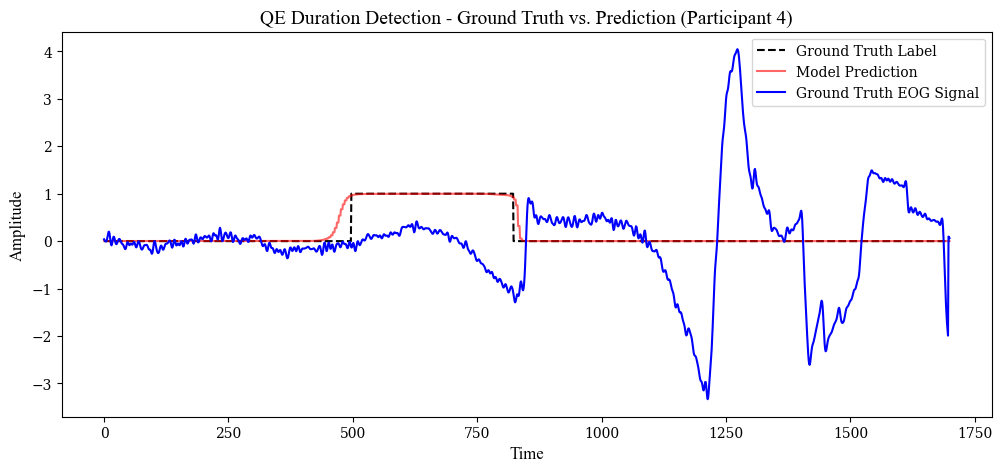

In [85]:
import matplotlib.pyplot as plt

# Modeli Yükleme ve Tahmin Yapma
predictions = cnngrumodel.predict(X_test)  # (60, 1700)

# Örnek Bir Test Verisi için Görselleştirme #görselleştireceğim test verileri 2-1, 5-2, 23-3, 12-4
test_index = 12
plt.figure(figsize=(12, 5))
plt.plot(Y_test[test_index], label='Ground Truth Label', color='black', linestyle='dashed')
plt.plot(predictions[test_index], label='Model Prediction',color='red', alpha=0.6)
plt.plot(X_test[test_index], label='Ground Truth EOG Signal', color='blue')

plt.legend()
plt.title('QE Duration Detection - Ground Truth vs. Prediction (Participant 4)', fontproperties=font_prop, size=14)
plt.xlabel('Time', fontproperties=font_prop,size=12)
plt.ylabel('Amplitude', fontproperties=font_prop,size=12)
# Yüksek çözünürlükle kaydetme (600 DPI)
plt.savefig('qe_prediction_cnngru_plot_participant4.png', dpi=600, bbox_inches='tight')

# Görseli gösterme
plt.show()


In [86]:
loss, accuracy = cnngrumodel.evaluate(X_test, Y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9162 - loss: 0.4671


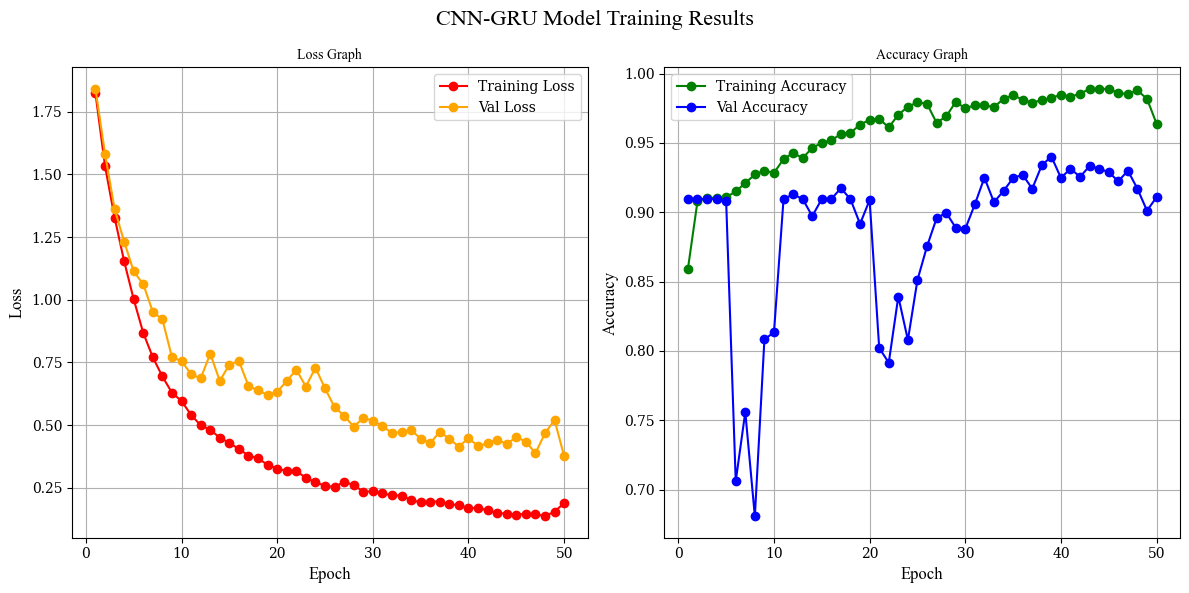

In [87]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path = '/content/times.ttf'  # Replace with the actual path
font_prop = FontProperties(fname=font_path)


# Model eğitimi sırasında elde edilen loss ve accuracy değerlerini history nesnesinden alıyoruz
# history = model.fit(...) işleminden sonra elde edilen sonuçlar
# history.history['loss'] ve history.history['accuracy'] ile erişilebilir

# Örnek history verisi (gerçek training işlemi sırasında history nesnesini kullanmalısınız)

# Eğitim geçmişinden loss ve accuracy değerlerini alıyoruz
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # Epoch sayısı

# Grafiği oluşturma
plt.figure(figsize=(12, 6))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='red', linestyle='-', marker='o')
plt.title('Loss Graph', fontsize=14, fontproperties=font_prop)
plt.plot(epochs, val_loss, label='Val Loss', color='orange', linestyle='-', marker='o')
plt.title('Loss Graph', fontsize=14, fontproperties=font_prop)
plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
plt.ylabel('Loss', fontsize=12, fontproperties=font_prop)
plt.grid(True)
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='green', linestyle='-', marker='o')
plt.title('Accuracy Graph', fontsize=14, fontproperties=font_prop)
plt.plot(epochs, val_accuracy, label='Val Accuracy', color='blue', linestyle='-', marker='o')
plt.title('Accuracy Graph', fontsize=14, fontproperties=font_prop)
plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
plt.ylabel('Accuracy', fontsize=12, fontproperties=font_prop)
plt.grid(True)
plt.legend()

# Genel başlık
plt.suptitle('CNN-GRU Model Training Results', fontsize=16, fontproperties=font_prop)

# Görseli gösterme
plt.tight_layout()
plt.savefig('CNN-GRU Model Results.png', dpi=600, bbox_inches='tight')

# Görseli gösterme
plt.show()


In [88]:
#####OTHER MODELS#####

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7870 - loss: 0.6187 - val_accuracy: 0.9096 - val_loss: 0.3181
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9107 - loss: 0.3119 - val_accuracy: 0.9096 - val_loss: 0.2930
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9105 - loss: 0.3011 - val_accuracy: 0.9096 - val_loss: 0.2936
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9142 - loss: 0.2896 - val_accuracy: 0.9096 - val_loss: 0.2915
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9157 - loss: 0.2839 - val_accuracy: 0.9096 - val_loss: 0.2891
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9092 - loss: 0.2980 - val_accuracy: 0.9096 - val_loss: 0.2875
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9080 - loss: 0.2995 - val_accuracy: 0.9096 - val_loss: 0.2899
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9086 - loss: 0.2920 - val_accuracy: 0.9095 - val_loss: 

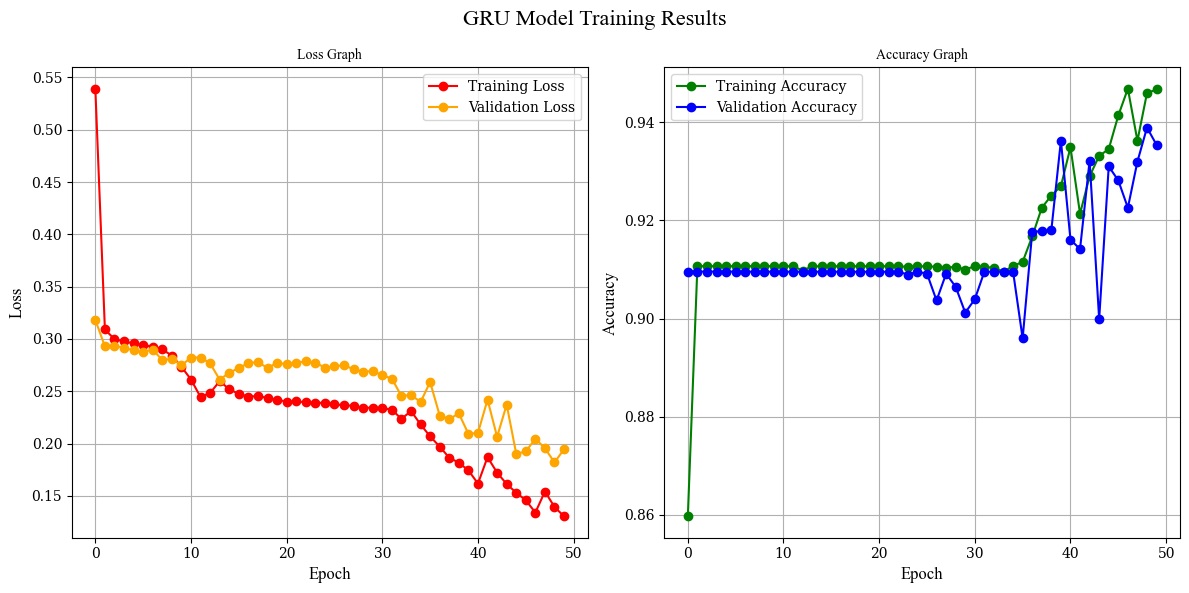

Training UNet...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7691 - loss: 0.5057 - val_accuracy: 0.9096 - val_loss: 0.3275
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9125 - loss: 0.3269 - val_accuracy: 0.9096 - val_loss: 0.3028
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9096 - loss: 0.3016 - val_accuracy: 0.9096 - val_loss: 0.2986
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9116 - loss: 0.2935 - val_accuracy: 0.9096 - val_loss: 0.2892
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9040 - loss: 0.3026 - val_accuracy: 0.9096 - val_loss: 0.2938
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9110 - loss: 0.2912 - val_accuracy: 0.9096 - val_loss: 0.2914
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9048 - loss: 0.2997 - val_accuracy: 0.9096 - val_loss: 0.2908
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9069 - loss: 0.2962 - val_ac

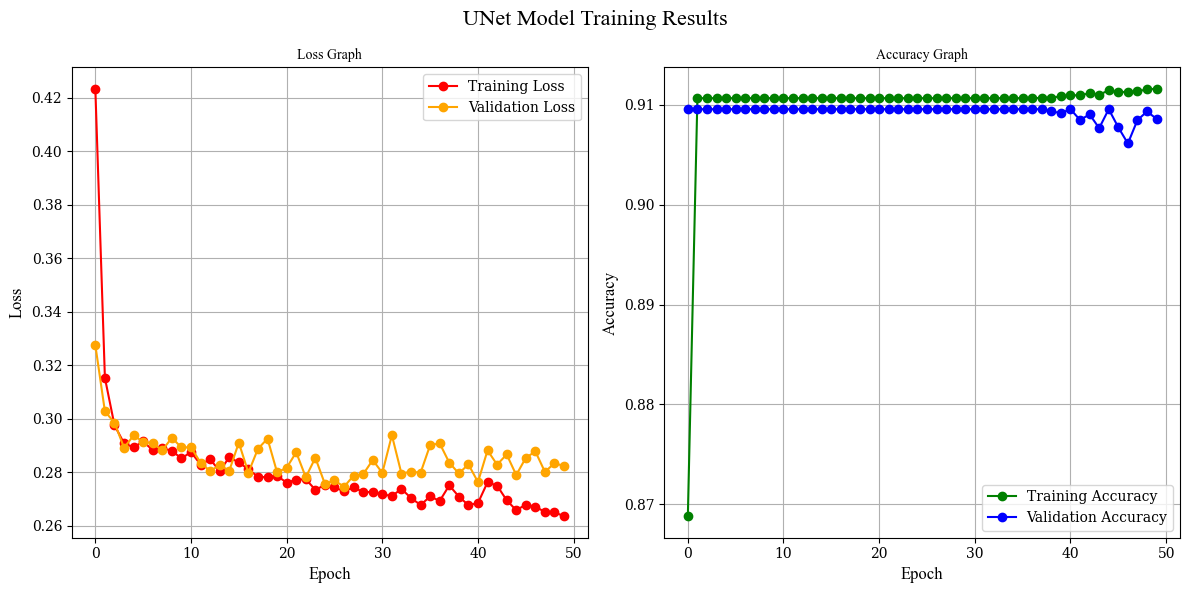

Training Transformer...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.7560 - loss: 0.5522 - val_accuracy: 0.9096 - val_loss: 0.3354
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9146 - loss: 0.3056 - val_accuracy: 0.9096 - val_loss: 0.3028
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9096 - loss: 0.3054 - val_accuracy: 0.9096 - val_loss: 0.3023
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9139 - loss: 0.2920 - val_accuracy: 0.9096 - val_loss: 0.2986
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9016 - loss: 0.3185 - val_accuracy: 0.9096 - val_loss: 0.2982
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9128 - loss: 0.2937 - val_accuracy: 0.9096 - val_loss: 0.2940
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9166 - loss: 0.2841 - val_accuracy: 0.9096 - val_loss: 0.2961
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9014 - loss: 0.3150 -

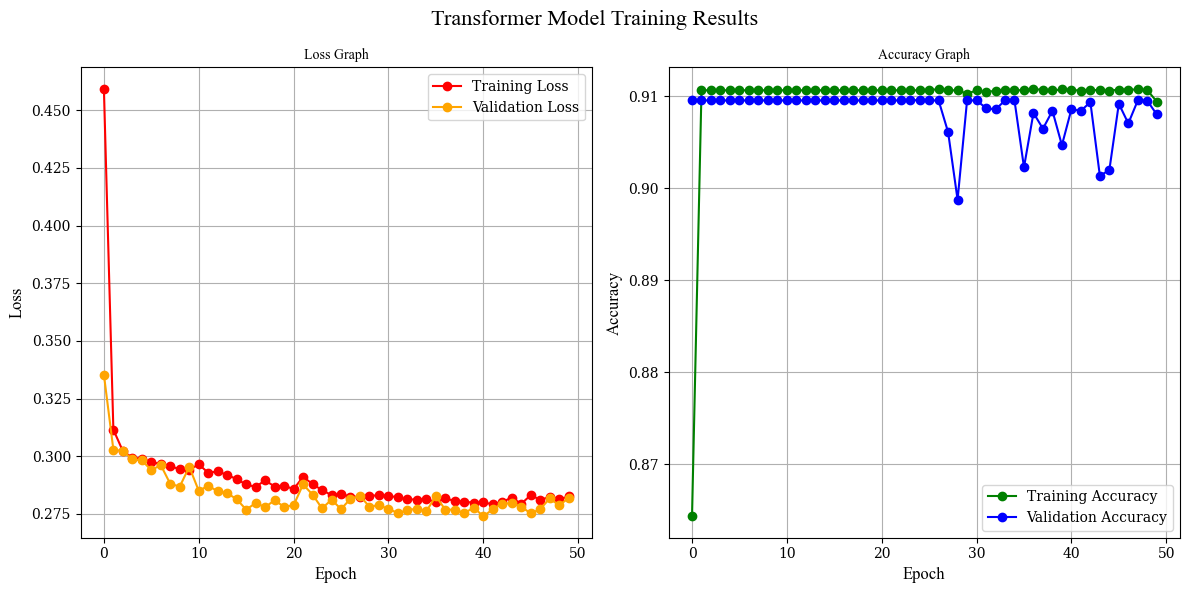

Training 1D CNN...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8692 - loss: 0.5331 - val_accuracy: 0.9096 - val_loss: 0.3299
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9105 - loss: 0.3352 - val_accuracy: 0.9096 - val_loss: 0.3083
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9137 - loss: 0.3065 - val_accuracy: 0.9096 - val_loss: 0.2953
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9128 - loss: 0.2916 - val_accuracy: 0.9096 - val_loss: 0.2914
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9108 - loss: 0.2957 - val_accuracy: 0.9096 - val_loss: 0.2901
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9124 - loss: 0.2898 - val_accuracy: 0.9096 - val_loss: 0.2920
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9100 - loss: 0.2933 - val_accuracy: 0.9096 - val_loss: 0.2909
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9089 - loss: 0.2950 - val_acc

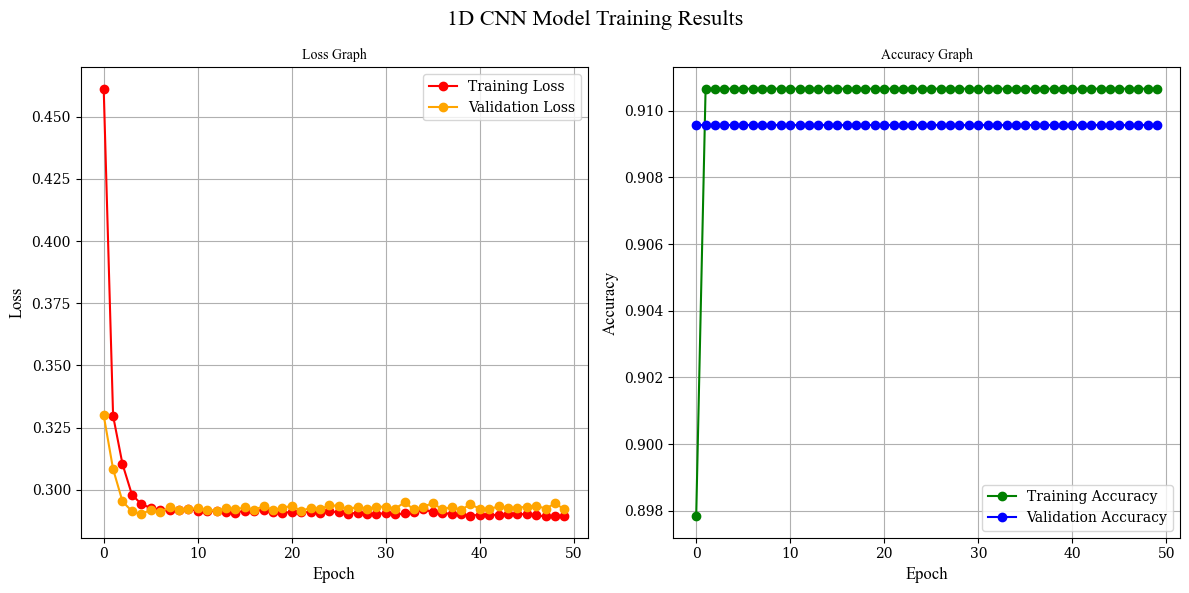

In [89]:
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, GRU, LSTM, Input, BatchNormalization, MaxPooling1D, UpSampling1D, Add, MultiHeadAttention, LayerNormalization
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, GRU, LSTM, Input, BatchNormalization, MaxPooling1D, UpSampling1D, Add, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path = '/content/times.ttf'  # Replace with the actual path
font_prop = FontProperties(fname=font_path)

# 1. GRU Modeli
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(32, return_sequences=True),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2. UNet Modeli
def build_unet_model(input_shape):
    inputs = Input(shape=input_shape)
    c1 = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling1D(2)(c1)
    c2 = Conv1D(128, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling1D(2)(c2)
    c3 = Conv1D(256, 3, activation='relu', padding='same')(p2)
    u1 = UpSampling1D(2)(c3)
    c4 = Conv1D(128, 3, activation='relu', padding='same')(u1)
    u2 = UpSampling1D(2)(c4)
    c5 = Conv1D(64, 3, activation='relu', padding='same')(u2)
    outputs = Conv1D(1, 1, activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Transformer Modeli
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([x, inputs])
    x = LayerNormalization()(x)
    outputs = Conv1D(1, kernel_size=1, activation='sigmoid')(x)  # Çıktıyı (batch_size, 1700, 1) yap
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# 4. 1D CNN Modeli
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same'),
        UpSampling1D(2),
        Conv1D(1, kernel_size=1, activation='sigmoid')  # Çıktıyı (batch_size, 1700, 1) yap
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Modelleri eğitme ve değerlendirme
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, model_name):
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=8, verbose=1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='red', linestyle='-', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='-', marker='o')
    plt.title('Loss Graph', fontsize=14, fontproperties=font_prop)
    plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
    plt.ylabel('Loss', fontsize=12, fontproperties=font_prop)
    plt.grid(True)
    plt.legend()
    #Acc
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='-', marker='o')
    plt.title('Accuracy Graph', fontsize=14, fontproperties=font_prop)
    plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
    plt.ylabel('Accuracy', fontsize=12, fontproperties=font_prop)
    plt.grid(True)
    plt.legend()
    # Genel başlık
    plt.suptitle(f'{model_name} Model Training Results', fontsize=16, fontproperties=font_prop)
    plt.tight_layout()
    plt.savefig(f'{model_name} Model Results.png', dpi=600, bbox_inches='tight')
    plt.show()

# Model Eğitimleri
models = {
    'GRU': build_gru_model(X_train.shape[1:]),
    'UNet': build_unet_model(X_train.shape[1:]),
    'Transformer': build_transformer_model(X_train.shape[1:]),
    '1D CNN': build_cnn_model(X_train.shape[1:])
}

for name, model in models.items():
    print(f'Training {name}...')
    train_and_evaluate(model, X_train, Y_train, X_test, Y_test, name)

Training LSTM...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - accuracy: 0.7803 - loss: 2.5495 - val_accuracy: 0.9096 - val_loss: 1.8921 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - accuracy: 0.9157 - loss: 1.7870 - val_accuracy: 0.9096 - val_loss: 1.4293 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.9117 - loss: 1.3545 - val_accuracy: 0.9096 - val_loss: 1.1242 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.9057 - loss: 1.0574 - val_accuracy: 0.9096 - val_loss: 0.8701 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.9172 - loss: 0.7832 - val_accuracy: 0.9096 - val_loss: 0.7193 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.9131 - loss: 0.6304 - val_accuracy: 0.9096 - val_loss: 0.5701 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 38

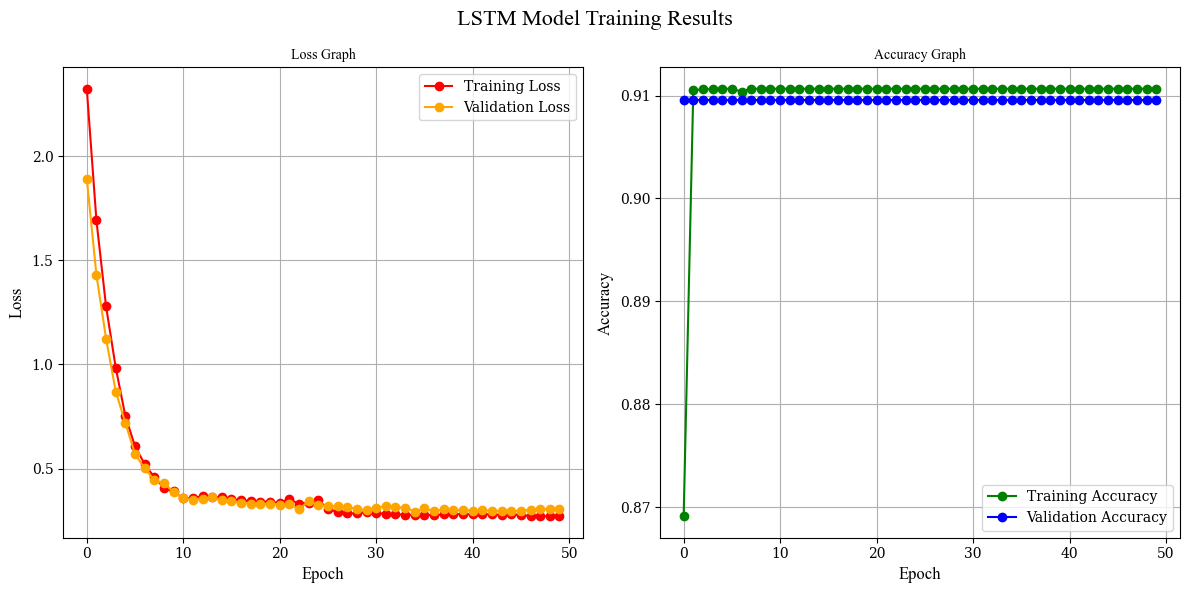

In [92]:
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, GRU, LSTM, Input, BatchNormalization, MaxPooling1D, UpSampling1D, Add, MultiHeadAttention, LayerNormalization
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, GRU, LSTM, Input, BatchNormalization, MaxPooling1D, UpSampling1D, Add, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path = '/content/times.ttf'  # Replace with the actual path
font_prop = FontProperties(fname=font_path)

# 1. lstm Modeli
def build_bd_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(190, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(190, return_sequences=True, kernel_regularizer=l2(0.001))))
    # Tam Bağlantılı Katman
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # Çıkış Katmanı (Sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    return model

    model.add(Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.001))))
    #model.add(Bidirectional(LSTM(200, return_sequences=True)))

    model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001))))
    #model.add(Bidirectional(LSTM(100, return_sequences=True)))

    #model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001))))

    # Çıkışı Orijinal Boyuta Döndürme
    model.add(UpSampling1D(size=2))
    model.add(UpSampling1D(size=2))

    # Tam Bağlantılı Katman
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # Çıkış Katmanı (Sigmoid)
    model.add(Dense(1, activation='sigmoid'))


# Modelleri eğitme ve değerlendirme
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, model_name):
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

    # Callback'ler
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)

    # Modeli Eğitme
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=8, callbacks=[early_stopping, lr_scheduler])

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='red', linestyle='-', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='-', marker='o')
    plt.title('Loss Graph', fontsize=14, fontproperties=font_prop)
    plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
    plt.ylabel('Loss', fontsize=12, fontproperties=font_prop)
    plt.grid(True)
    plt.legend()
    #Acc
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='-', marker='o')
    plt.title('Accuracy Graph', fontsize=14, fontproperties=font_prop)
    plt.xlabel('Epoch', fontsize=12, fontproperties=font_prop)
    plt.ylabel('Accuracy', fontsize=12, fontproperties=font_prop)
    plt.grid(True)
    plt.legend()
    # Genel başlık
    plt.suptitle(f'{model_name} Model Training Results', fontsize=16, fontproperties=font_prop)
    plt.tight_layout()
    plt.savefig(f'{model_name} Model Results.png', dpi=600, bbox_inches='tight')
    plt.show()

# Model Eğitimleri
models = {
    'LSTM': build_bd_lstm_model(X_train.shape[1:]),
}

for name, model in models.items():
    print(f'Training {name}...')
    train_and_evaluate(model, X_train, Y_train, X_test, Y_test, name)